# Differential expression

One of the main applications of metabolic RNA labeling is to identify differentially expressed genes upon some perturbation [[1]](https://www.nature.com/articles/s41586-019-1369-y). The main benefit of using metabolic RNA labeling is that short-term changes can be resolved much better as compared to standard RNA-seq, since any changes of transcription that indeed happened are masked to some extent by pre-existing RNA.

To perform differential analyses for data from [[2]](https://www.nature.com/articles/s41586-021-03689-8). These are SLAM-seq data from multiple time points (1h, 2h, 4h, 6h and 20h) after acute depletion of BANP. BANP is a transcriptional activator that binds to unmethylated CGCG motifs in CpG island promoters.

# Loading data and QC
We first load the grandPy package and then read the GRAND-SLAM output table directly from zenodo:

In [1]:
# loading the grandPy package anpassen
from Py.load import *
banp = read_grand("https://zenodo.org/record/6976391/files/BANP.tsv.gz", design=("Cell", "Experimental.time", "Genotype", "dur.4sU", "has4.U", "Replicate"))

Detected URL -> downloading to temp file
Detected dense format -> using dense reader


C:\Users\User\PycharmProjects\grandpy\Py\utils.py:60: UserWarning: 34 Duplicate gene symbols found: Gm16701, Sept2, Gm2464, Jakmip1, Dancr (first 5); they have been renamed to ensure uniqueness (e.g., MATR3 → MATR3_1).
  warnings.warn(f"{len(duplicates_list)} Duplicate gene symbols found: {', '.join(duplicates_list[:5])} (first 5); they have been renamed to ensure uniqueness (e.g., MATR3 → MATR3_1).")


Refer to the [Loading data and working with grandPy objects](vignette_03_loading_data_and_working_with_grandPy_objects.ipynb) vignette to learn more about how to load data. Note that sample metadata has been automatically extracted from the sample names via the design parameter given to `read_grand`:

In [2]:
print(banp.coldata)
# duration.4sU.original?
#TODO: no4sU column ist falsch!

                                                  Name  Cell  \
Name                                                           
mESC.0h.wt.0h.no4sU.A            mESC.0h.wt.0h.no4sU.A  mESC   
mESC.0h.wt.0h.no4sU.B            mESC.0h.wt.0h.no4sU.B  mESC   
mESC.0h.wt.0h.no4sU.C            mESC.0h.wt.0h.no4sU.C  mESC   
mESC.0h.wt.2h.4sU.A                mESC.0h.wt.2h.4sU.A  mESC   
mESC.0h.wt.2h.4sU.B                mESC.0h.wt.2h.4sU.B  mESC   
mESC.0h.wt.2h.4sU.C                mESC.0h.wt.2h.4sU.C  mESC   
mESC.0h.dTag.2h.4sU.A            mESC.0h.dTag.2h.4sU.A  mESC   
mESC.0h.dTag.2h.4sU.B            mESC.0h.dTag.2h.4sU.B  mESC   
mESC.1h.dTag.30min.4sU.A      mESC.1h.dTag.30min.4sU.A  mESC   
mESC.1h.dTag.30min.4sU.B      mESC.1h.dTag.30min.4sU.B  mESC   
mESC.1h.dTag.30min.4sU.C      mESC.1h.dTag.30min.4sU.C  mESC   
mESC.2h.dTag.90min.4sU.A      mESC.2h.dTag.90min.4sU.A  mESC   
mESC.2h.dTag.90min.4sU.B      mESC.2h.dTag.90min.4sU.B  mESC   
mESC.2h.dTag.90min.4sU.C      mESC.2h.dT

The experimental time column indicates the period of time the sample was treated with the dTAG13 compound that induces acute depletion of BANP within 30 minutes

By default GRAND-SLAM will report data on all genes (with at least one mapped read), and `read_grand` will read all these genes from the output:

In [3]:
print(banp)

GrandPy:
Read from BANP.tsv
24616 genes, 23 samples/cells
Available data slots: ['count', 'ntr', 'alpha', 'beta']
Available analyses: []
Available plots: {}
Default data slot: count



Thus, we filter to only include genes that have at least 100 reads in at least 11 samples:

In [4]:
banp = banp.filter_genes(min_expression=100, min_columns=11)
print(banp)

GrandPy:
Read from BANP.tsv
11147 genes, 23 samples/cells
Available data slots: ['count', 'ntr', 'alpha', 'beta']
Available analyses: []
Available plots: {}
Default data slot: count



The actual data is available in so-called "data slots". `read_grand` adds the read counts, new to toal RNA ratios (NTRs) and information on the NTR posterior distribution (alpha, beta).

As a quick quality check, we can inspect a principal component analysis of all samples involved:

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.12 seconds.

Fitting dispersion trend curve...
... done in 0.19 seconds.

Fitting MAP dispersions...
... done in 1.55 seconds.

Fitting LFCs...
... done in 0.70 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 11 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.11 seconds.



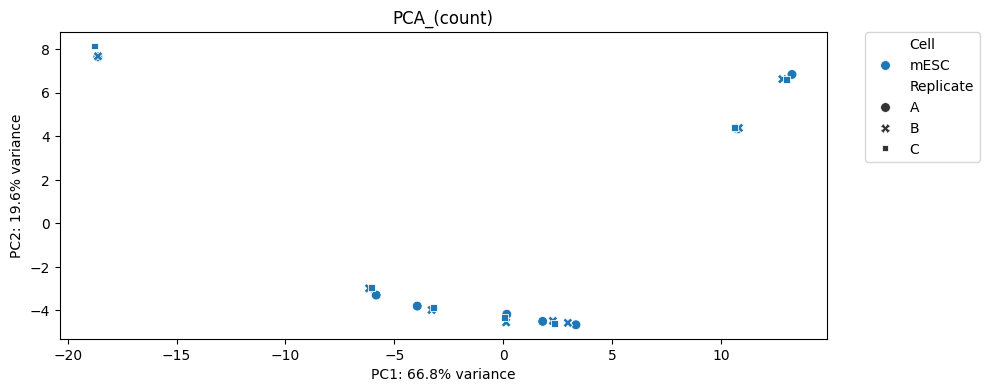

In [5]:
from Py.plot import *
plot_pca(banp)